<a href="https://colab.research.google.com/github/riverdogcabin/PSDS4900/blob/main/wu_observation_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
from numpy import arange
import scipy.stats as stats
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter
from matplotlib import cm
import seaborn as sns
from pprint import pprint
import json
from time import sleep

In [3]:
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV, KFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, FactorAnalysis, NMF
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [4]:
best_model_tracker = {}

In [5]:
with open('/content/drive/MyDrive/Capstone/PSDS4900/config.json') as configuration:
  my_station = json.load(configuration).get('WU')["stationid"] #'WU' is the parameters for WeatherUnderground

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Capstone/PSDS4900/wu_data/wu_observations.csv')
df['timestamp'] = pd.to_datetime(df['epoch'], unit='s')
df = df.assign(timestamp_rounded=df.timestamp.dt.round('60min')) #rounded to the hour
print('with dupes',df.shape)
before = df.shape[0]
df.drop_duplicates(inplace=True)
print('without dupes',df.shape)
print('difference: ',before-df.shape[0])

with dupes (174982, 34)
without dupes (174982, 34)
difference:  0


### Helper function to grab the N most correlated stations from a big correlation matrix of all statiosn based on one variable (defaul windspeedAvg)

In [7]:
def get_top_n_correlated_old(df,corr_df,num_stations=5,variable='windspeedAvg',my_station='KCOPARKE414'):
  target_stations = corr_df.sort_values(variable+'_corr',ascending=False).stationID.to_list()[:num_stations]
  target_stations.append(my_station)
  df_filtered = df[df.stationID.isin(target_stations)]
  df_reshaped = df_filtered.pivot_table(index='timestamp_rounded',columns='stationID',values=variable)
  before = df_reshaped.shape[0]
  df_reshaped.dropna(inplace=True)
  return df_reshaped, before-df_reshaped.shape[0]

In [8]:
def get_top_n_correlated(df,corr_df,num_stations=5,variable=['windspeedAvg'],my_station='KCOPARKE414',target_variable='windspeedAvg'):
  if(isinstance(variable,str)):
    variable = [variable]
  df_reshaped = pd.DataFrame()
  for var in variable:
    target_stations = corr_df.sort_values(var+'_corr',ascending=False).stationID.to_list()[:num_stations]
    # target_stations.append(my_station)
    df_filtered = df[df.stationID.isin(target_stations)]
    if (df_reshaped.shape[0]>0):
      df_reshaped = pd.concat([df_reshaped, df_filtered.pivot_table(index='timestamp_rounded',columns='stationID',values=var)], axis=1)
    else:
      df_reshaped = df_filtered.pivot_table(index='timestamp_rounded',columns='stationID',values=var)
      # before = df_reshaped.shape[0]
  # append my_station windspeedAvg so we have a y target
  df_filtered = df[df.stationID.isin([my_station])]
  df_reshaped = pd.concat([df_reshaped, df_filtered.pivot_table(index='timestamp_rounded',columns='stationID',values=target_variable)], axis=1)
  df_reshaped.dropna(inplace=True)
  return df_reshaped

In [9]:
# df_reshaped = get_top_n_correlated(df,corr_df,num_stations=3,variable=columns_to_pull)
# df_reshaped.head()
# corr_df.head()

In [10]:
# # df_reshaped,dropped = get_top_n_correlated_old(df,corr_df,num_stations=3)
# df_reshaped,dropped = get_top_n_correlated_old(df,corr_df,num_stations=3,variable='windgustAvg')
# # df_reshaped.columns.to_list()
# df_reshaped.index.name = None
# df_reshaped.columns.name = None
# df_reshaped.head()

### Clean up the spikes (dupes in each timegroup as outline din the stats notebook)

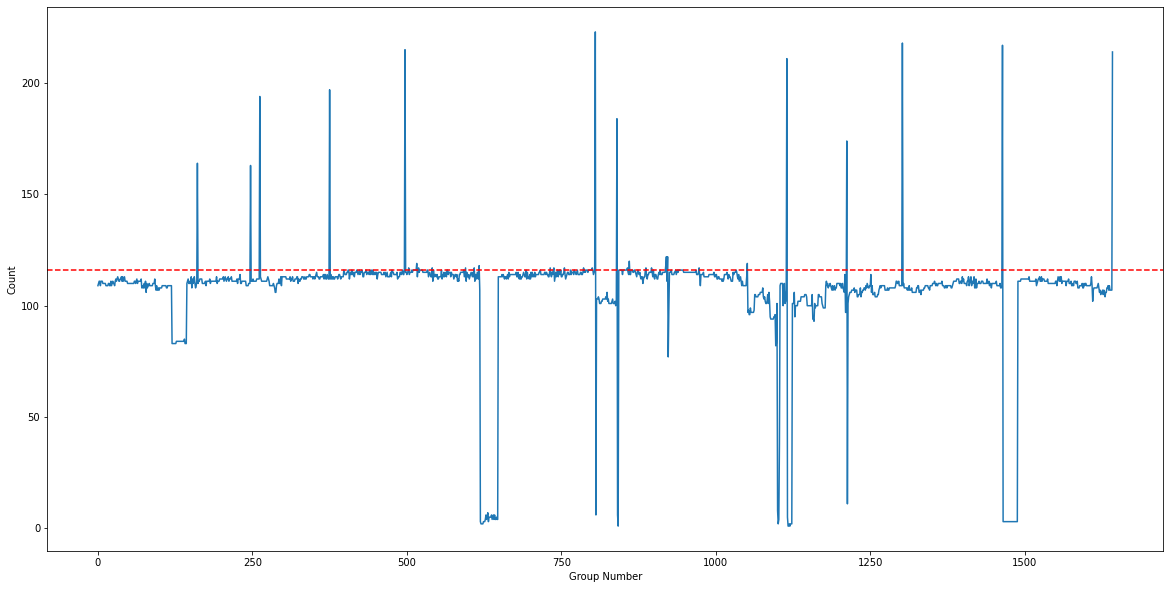

In [11]:
num_stations = len(df.stationID.unique())
counted_df = df.groupby(['timestamp_rounded']).count().reset_index()
ax = counted_df.windspeedAvg.plot(xlabel='Group Number',ylabel='Count',figsize=(20, 10))
ax.axhline(y=num_stations,color='red',linestyle='--')
hour_grouping_std = counted_df.stationID.std()
# problem_hours = list(counted_df[counted_df.stationID > num_stations+hour_grouping_std].timestamp_rounded) #get all groups that are more than one standard deviation off the station count
# indices_to_drop = df[(df.timestamp_rounded.isin(problem_hours)) & (df.timestamp > df.timestamp_rounded)].index
# df.drop(indices_to_drop,inplace=True)

In [12]:
timestamp_target_dict = {}
timestamp_groups_to_remove = []
for tsr in set(df.timestamp_rounded):
  # print(tsr)
  target_timestamp = df[(df.stationID == my_station) & (df.timestamp_rounded == tsr)]
  # if(tsr == pd.to_datetime('2021-04-20 16:00:00')):
  #   print(target_timestamp)
  if(not target_timestamp.empty):
    timestamp_target_dict[tsr] = target_timestamp.loc[target_timestamp.timestamp.idxmax()].timestamp
  else:
    timestamp_groups_to_remove.append(tsr) #timestamp group does not contain my station
# timestamp_target_dict

In [13]:
#get rid of timestamp groups that do not contain my station
df.drop(df[df.timestamp_rounded.isin(timestamp_groups_to_remove)].index,inplace=True)
df.reset_index(drop=True,inplace=True)

In [14]:
#create target_timestamp and use it to create the offsets so we can only keep observations closest to my_station
df['target_timestamp'] = df.timestamp_rounded.map(timestamp_target_dict)
df['offset'] = df.apply(lambda x: abs((x.timestamp-x.target_timestamp).total_seconds()),axis=1)

In [15]:
bad_indices = []
problem_hours = list(counted_df[counted_df.stationID > num_stations+hour_grouping_std].timestamp_rounded)

for hour in problem_hours:
  grouped = df[df.timestamp_rounded == hour].groupby('stationID')
  for group in grouped.groups:
    if(np.isnan(grouped.get_group(group).offset.idxmax())):
      print(group, hour)
    bad_indices.append(grouped.get_group(group).offset.idxmax())

bad_indices = bad_indices + list(df[df.timestamp_rounded.isin(timestamp_groups_to_remove)].index)
# drop bad_indices and reset index
df.drop(bad_indices,inplace=True)
df.reset_index(inplace=True, drop=True)
print("Dropped {} rows".format(len(bad_indices)))

Dropped 1109 rows


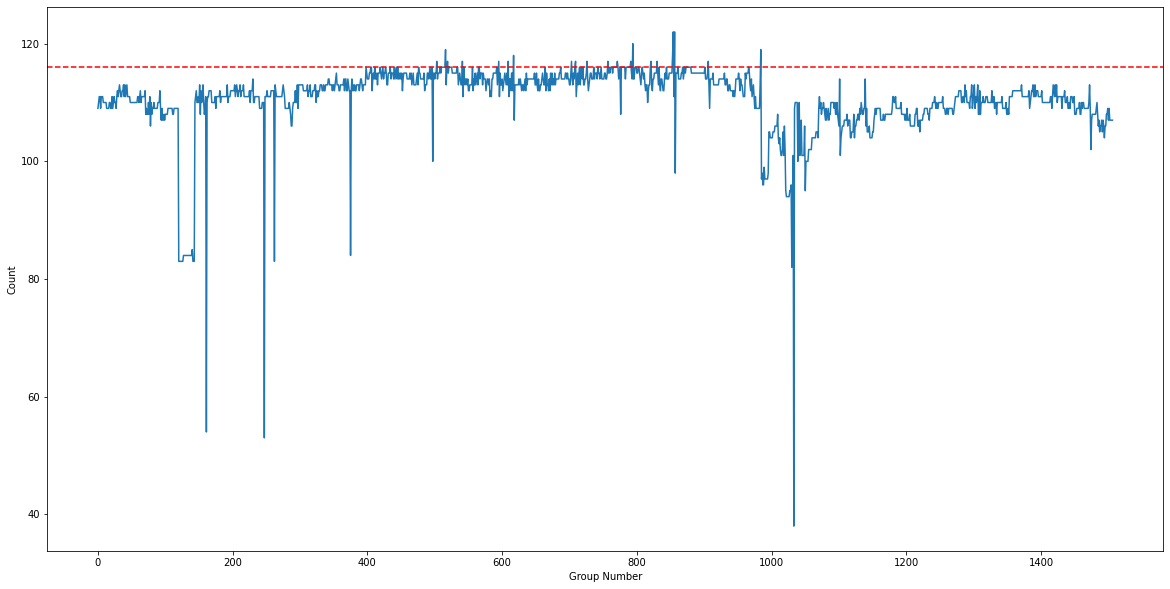

In [16]:
## uncomment the below to check to make sure the spikes are gone
grouped = df.groupby(['timestamp_rounded'])
ax = grouped.count().reset_index().windspeedAvg.plot(xlabel='Group Number',ylabel='Count',figsize=(20, 10))
ax.axhline(y=num_stations,color='red',linestyle='--')

In [17]:
#Quick check just within the data from my_station to see which data are most highly correlated with windspeedAvg
df[df.stationID == my_station].corr()[['windspeedAvg']].sort_values(by='windspeedAvg', ascending=False).head(10)


,windspeedAvg
windspeedAvg,1.000000
windgustAvg,0.995071
windspeedHigh,0.852027
windgustHigh,0.838374
windgustLow,0.523414
windspeedLow,0.459209
solarRadiationHigh,0.370677
uvHigh,0.364316
tempHigh,0.286263
windchillHigh,0.286250


In [18]:
#take all the variables that are correlated > .8 within my_station's readings
columns_to_pull = df[df.stationID == my_station].corr()[['windspeedAvg']].sort_values(by='windspeedAvg', ascending=False)
columns_to_pull = columns_to_pull[columns_to_pull.windspeedAvg > 0.80].index.to_list()
columns_to_pull

['windspeedAvg', 'windgustAvg', 'windspeedHigh', 'windgustHigh']

### Build correlation DataFrame and the dict of maximally correlated stations

In [19]:
# columns_to_check = [s for s in df.columns if "Avg" in s]
corr_df = pd.DataFrame({'stationID':df.stationID.unique()}) #create the shell of the dataframe to store the correlations
max_correlations = {} #this will hold the maximally correlated stations for each variable
for v in columns_to_pull:
  #create a pivot table for each variable
  temp_df = df.pivot_table(index='timestamp_rounded',columns='stationID',values=v).corr()[[my_station]]
  temp_df.columns.name = None #get rid of the column names and then collapse the indices, reindex and rename the columns
  temp_df = temp_df.stack().reset_index().drop(columns='level_1').rename(columns={0:v+'_corr'})
  #get rid of the results for my_station, obvs 
  temp_df = temp_df[temp_df.stationID != my_station]
  #collect the maximally correlated station for the variable
  max_correlations[v] = temp_df.loc[temp_df[v+'_corr'].abs().idxmax()]
  #add all the corrleations for this variable as a column to the big correlation dataframe
  corr_df = corr_df.merge(temp_df,on='stationID')

### Doing some exploratory plotting for windspeedAvg for my station versus the top 5 correlated stations

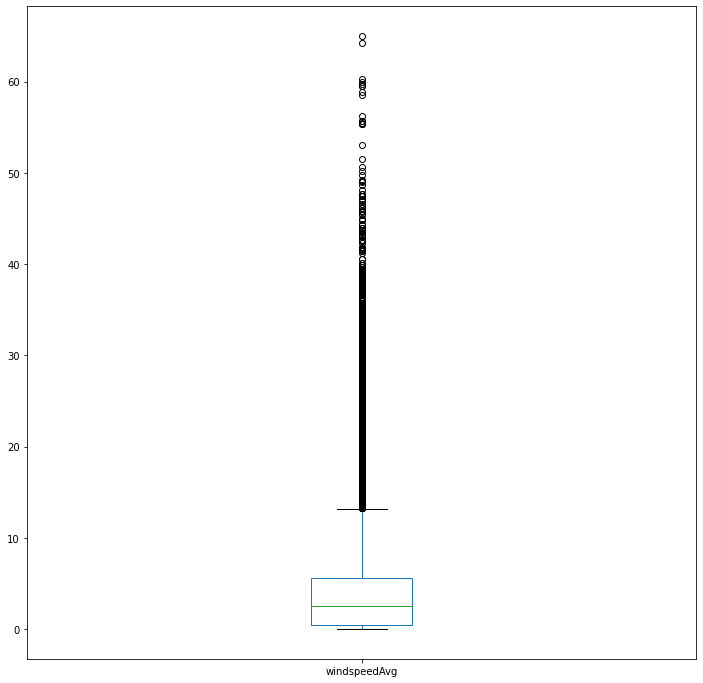

In [20]:
# taking a look at the distribution of windspeedAvg
df.windspeedAvg.plot(kind='box', figsize=(12,12))

In [21]:
df.windspeedAvg.describe()

count    166616.00000
mean          3.96106
std           4.75741
min           0.00000
25%           0.50000
50%           2.50000
75%           5.60000
max          65.00000
Name: windspeedAvg, dtype: float64

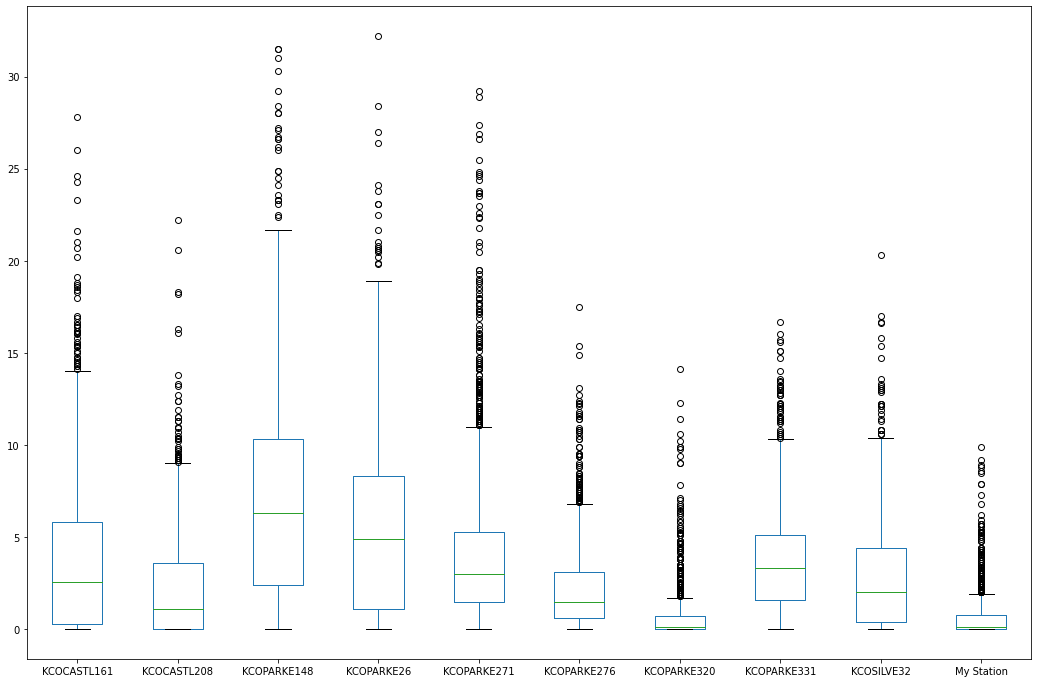

In [22]:
# taking a look at the distribution of windspeedAvg
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=9)
#need to flatten and stack all the windspeedAvg values
df_reshaped.rename(columns={my_station:'My Station'}, inplace=True)
df_reshaped.plot(kind='box', figsize=(18,12))

In [23]:
df_reshaped.describe()

stationID,KCOCASTL161,KCOCASTL208,KCOPARKE148,KCOPARKE26,KCOPARKE271,KCOPARKE276,KCOPARKE320,KCOPARKE331,KCOSILVE32,My Station
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,3.785022,2.238893,7.021961,5.496237,4.422938,2.257742,0.667438,3.659696,2.821708,0.653256
std,4.267610,2.842962,5.615873,4.852685,4.627468,2.395209,1.411347,2.790242,2.901917,1.229195
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.300000,0.000000,2.400000,1.100000,1.500000,0.600000,0.000000,1.600000,0.400000,0.000000
50%,2.550000,1.100000,6.300000,4.900000,3.000000,1.500000,0.100000,3.300000,2.000000,0.100000
75%,5.800000,3.600000,10.300000,8.300000,5.300000,3.100000,0.700000,5.100000,4.400000,0.775000
max,27.800000,22.200000,31.500000,32.200000,29.200000,17.500000,14.100000,16.700000,20.300000,9.900000


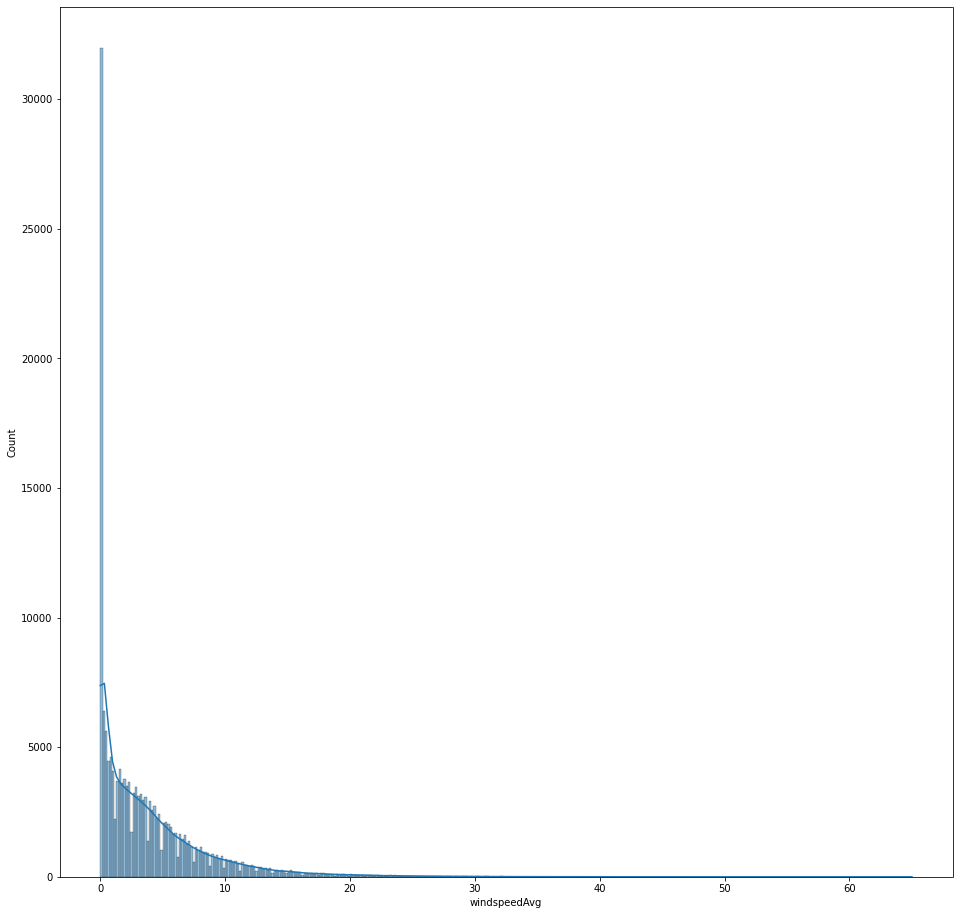

In [24]:
fig, ax = plt.subplots(figsize=(16,16))
sns.histplot(data=df, x="windspeedAvg", kde=True,ax=ax)

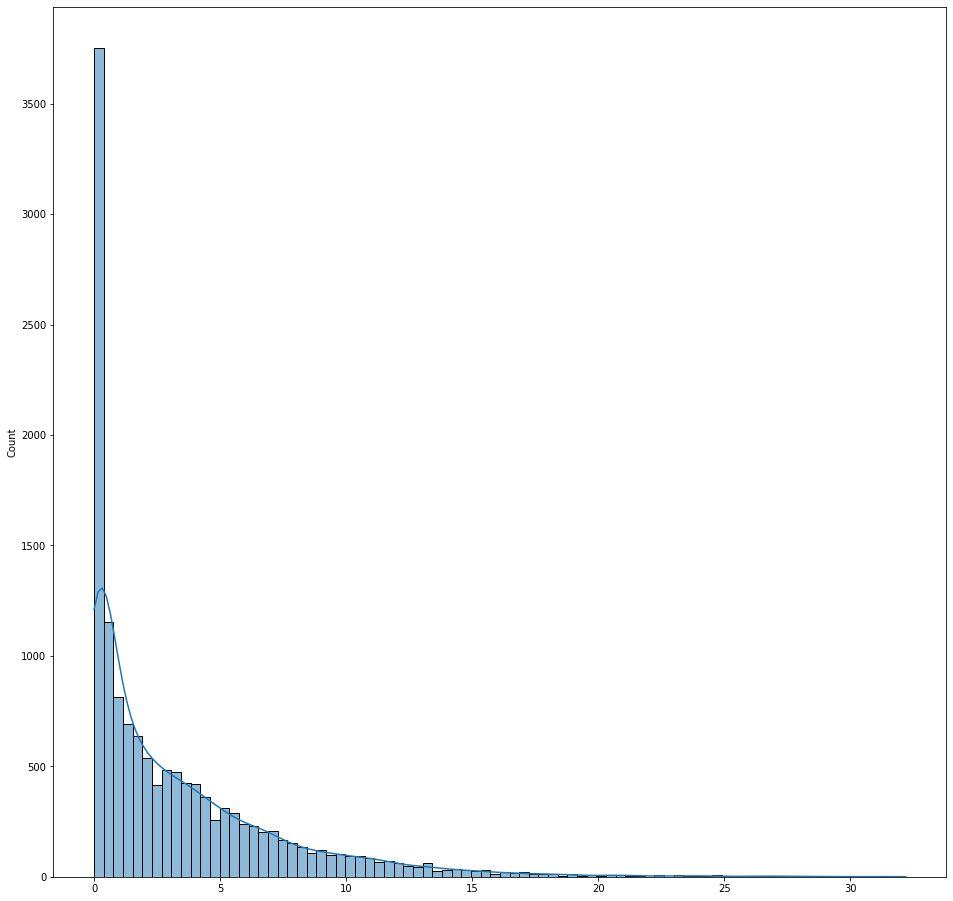

In [25]:
to_plot = []
for col in df_reshaped.columns:
  to_plot += df_reshaped[col].to_list()

fig, ax = plt.subplots(figsize=(16,16))
sns.histplot(data=to_plot, kde=True,ax=ax)

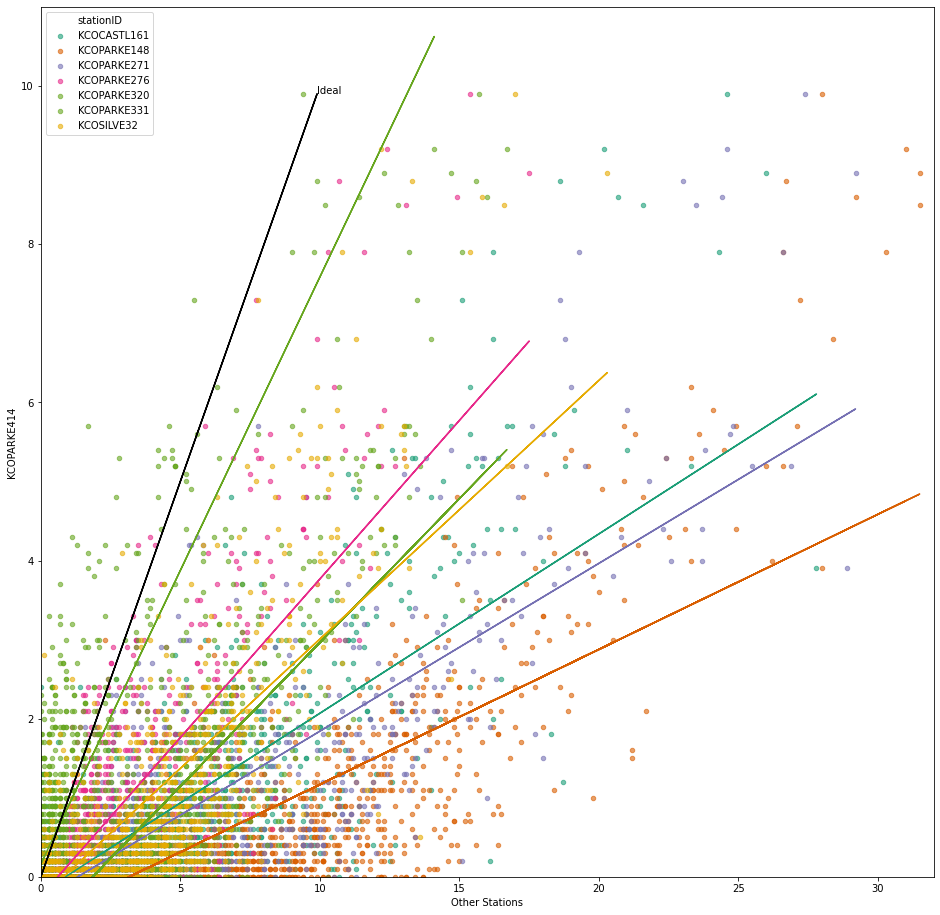

In [43]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=7)

columns_to_plot = list(df_reshaped.columns)
columns_to_plot.remove(my_station)
i = 0
colors = 'rgbym'
cmap = cm.get_cmap('Dark2')
cmap_counter = 0.1
cmap_tracker = {}

fig, ax = plt.subplots(figsize=(16,16))
# ax.set_aspect('equal')
# ax.set_xlim((0,30))
# ax.set_ylim((0,30))
for col in columns_to_plot:
  df_reshaped.plot(ax=ax, kind='scatter',y=my_station,x=col,color=cmap(cmap_counter),label=col,alpha=0.6)
  m, b = np.polyfit(df_reshaped[col], df_reshaped[my_station], 1)
  # ax.plot(df_reshaped[my_station],m*df_reshaped[my_station]+b, color=colors[i])
  ax.plot(df_reshaped[col],m*df_reshaped[col]+b, color=cmap(cmap_counter)) 
  cmap_tracker[col] = cmap(cmap_counter)
  i += 1
  cmap_counter += .1
ax.plot(df_reshaped[my_station],df_reshaped[my_station],c='k')
ax.text(df_reshaped[my_station].max()+.01, df_reshaped[my_station].max(), 'Ideal')
ax.set_xlabel('Other Stations')
plt.xlim(0,32)
plt.ylim(0,11)
plt.show()

### Now let's build a simple linear regression model and test it. Found a [ great code snippet to set up k-fold cross validation](https://becominghuman.ai/linear-regression-in-python-with-pandas-scikit-learn-72574a2ec1a5) and adapted it. After trial and error, it appears that the windspeedAvg from the 7 most correlated weather stations provide the best accuracy.

In [27]:
for j in range(1,11):
  df_reshaped = get_top_n_correlated(df,corr_df,num_stations=j,variable=columns_to_pull)
  X = pd.DataFrame(df_reshaped.drop(columns=my_station))
  y = pd.DataFrame(df_reshaped[[my_station]]) #target

  model = LinearRegression()
  scores = []
  kfold = KFold(n_splits=3, shuffle=True, random_state=42)

  for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train,:])
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    scores.append(score)
  print('{} features\nscores: {}\nAverage Score: {:.2f} Std: {:.2f}'.format(j,scores,np.mean(scores),np.std(scores)))

1 features
scores: [0.8298973591403154, 0.7758966006721212, 0.7498931907850884]
Average Score: 0.79 Std: 0.03
2 features
scores: [0.8478771646554434, 0.8107861007158509, 0.7997016205295753]
Average Score: 0.82 Std: 0.02
3 features
scores: [0.8409403874662718, 0.820270447156958, 0.8547238727770328]
Average Score: 0.84 Std: 0.01
4 features
scores: [0.8571898212215167, 0.8388251396085772, 0.8255896030000998]
Average Score: 0.84 Std: 0.01
5 features
scores: [0.8744914283597334, 0.8263233664309622, 0.846884888417215]
Average Score: 0.85 Std: 0.02
6 features
scores: [0.8374043875516997, 0.8822209754535478, 0.7853113563542177]
Average Score: 0.83 Std: 0.04
7 features
scores: [0.8782210876891212, 0.8291928674951632, 0.8668731668695466]
Average Score: 0.86 Std: 0.02
8 features
scores: [0.8734826770745615, 0.8225503480572592, 0.8665586701604144]
Average Score: 0.85 Std: 0.02
9 features
scores: [0.873016808258143, 0.8238788484448281, 0.8663395362420421]
Average Score: 0.85 Std: 0.02
10 features
s

Trying LinearRegression with 7 stations and including a StandardScaler

In [28]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=7,variable=columns_to_pull)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
model = LinearRegression()
model.fit(X_train_scaled,y_train)

scores = cross_val_score(model,scaler.transform(X_test),y_test)
print('scores: {}\nAverage Score: {:.2f} Std: {:.2f}'.format(scores,np.mean(scores),np.std(scores) ))
best_model_tracker['LinearRegression']= {'num_stations':7,'best_params': None, 'best_avg':np.mean(scores)}

scores: [0.88769829 0.75988726 0.88169377 0.81334863 0.80505654]
Average Score: 0.83 Std: 0.05


### Trying Lasso regression with cross validation. We will try it with the first 10 most correlated stations.

In [29]:
for i in range(1,11):
  df_reshaped = get_top_n_correlated(df,corr_df,num_stations=i,variable=columns_to_pull)
  X = pd.DataFrame(df_reshaped.drop(columns=my_station))
  y = pd.DataFrame(df_reshaped[[my_station]]) #target
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
  #define cross-validation method to evaluate model
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

  #define model
  model = LassoCV(cv=cv, n_jobs=-1)
  #fit model
  # model.fit(X, y)

  #display lambda that produced the lowest test MSE
  # print(model.alpha_)

  scores = cross_val_score(model,X,np.array(y).ravel())
  print('{} features\nscores: {}\nAverage Score: {:.2f}'.format(i,scores,np.mean(scores) ))

1 features
scores: [0.61807743 0.8129623  0.66821153 0.73384472 0.86193555]
Average Score: 0.74
2 features
scores: [0.68512951 0.83590758 0.73057098 0.77727971 0.87949722]
Average Score: 0.78
3 features
scores: [0.69836017 0.85593173 0.81146461 0.78180471 0.88204392]
Average Score: 0.81
4 features
scores: [0.71009316 0.85890554 0.79989763 0.77786728 0.88973338]
Average Score: 0.81
5 features
scores: [0.71000947 0.86048286 0.80348202 0.7808976  0.88618888]
Average Score: 0.81
6 features
scores: [0.70598163 0.85819392 0.78567776 0.78395952 0.88468551]
Average Score: 0.80
7 features
scores: [0.7469961  0.86990436 0.75025013 0.80844571 0.90677365]
Average Score: 0.82
8 features
scores: [0.74994394 0.87294404 0.7460293  0.80726122 0.90297141]
Average Score: 0.82
9 features
scores: [0.75197832 0.86828086 0.73986021 0.80712201 0.90253815]
Average Score: 0.81
10 features
scores: [0.75693478 0.87954225 0.6615186  0.82358641 0.88426017]
Average Score: 0.80


It appears that for plain Alpha of 1 that 5 stations is the right answer for Lasso.  Setting up a simple GridSearchCV to try different alphas to see if we can tune it and get better accuracy.

In [30]:
ALPHAS=arange(0.01, 1.00, 0.01)

df_reshaped = get_top_n_correlated(df,corr_df,num_stations=5,variable=columns_to_pull)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

pipe = Pipeline([
    ('regressor', Lasso())
])

param_grid = [
    {
        'regressor__alpha': ALPHAS
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('regressor',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='deprecated', n_jobs=1,
             param_grid=[{'regressor__alpha': array([0.01, 0....
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 

In [31]:
# print("Accuracy: ", accuracy_score(y_test, y_pred))
# print('f1 score: ',f1_score(y_test,y_pred), 'with grid parameters:')
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['Lasso']= {'num_stations':5,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha': 0.01}
scores: [0.7691877  0.78329103 0.70901109 0.65763686 0.66059384]
Average Score: 0.72


### That doesn't some as too much of a surprise. The data wasn't sparse enough to really make the most use out of Lasso. Also, the fact that the best fit results for the grid search turned out to have an alpha of 0.01 means that we should go with a regular LinearRegression instead of Lasso since when alpha == 0 Lasso is just OLS.

In [32]:

ALPHAS=arange(.01,0.1,0.01)
NORMALIZE = [False,True]

df_reshaped = get_top_n_correlated(df,corr_df,num_stations=7,variable=columns_to_pull) #using the best # stations that we found for LinearRegression
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

pipe = Pipeline([
    ('regressor', Ridge())
])

param_grid = [
    {
        'regressor__alpha': ALPHAS,
        'regressor__normalize': NORMALIZE
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('regressor',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=1,
             param_grid=[{'regressor__alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                          'regressor__normalize': [False, True]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [33]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['Ridge']= {'num_stations':7,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha': 0.09, 'regressor__normalize': False}
scores: [0.78156696 0.65624608 0.6959074  0.83008579 0.649114  ]
Average Score: 0.72


GridSearch with RandomForestRegressor

In [34]:
N_FEATURES_OPTIONS = ["auto","sqrt","log2"]
ESTIMATOR_OPTIONS = [10, 15, 20, 25, 50]
MAX_DEPTH_OPTIONS = [75, 85, 90, 95, 100]

df_reshaped = get_top_n_correlated(df,corr_df,num_stations=7,variable=columns_to_pull)
X = np.array(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]).flatten() #target

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.1)

pipe = Pipeline([
    # ('reduce_dim', SelectKBest()),
    ('classify', RandomForestRegressor())
])

param_grid = [
    {
        'classify__max_features': N_FEATURES_OPTIONS,
        'classify__n_estimators': ESTIMATOR_OPTIONS,
        'classify__max_depth' : MAX_DEPTH_OPTIONS
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('classify',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                  

In [35]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['RandomForestRegressor']= {'num_stations':7,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'classify__max_depth': 75, 'classify__max_features': 'log2', 'classify__n_estimators': 50}
scores: [ 0.87056873  0.85717288  0.89674398 -0.46194735  0.43427699]
Average Score: 0.52


Elastic Net - possibly of value as it is effective when we have multiple values correlated to one another. In theory, the windspeedAvg of stations highly correlated with mine should be highly correlated to one another.

In [36]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=7,variable=columns_to_pull) #using the best # stations that we found for LinearRegression
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

# alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=False

ALPHAS = arange(.01,0.1,0.01)
NORMALIZE = [False,True]
L1S = arange(.1,1.1,.1)
MAX_ITER = [1500, 2000, 2500]

pipe = Pipeline([
    ('regressor', ElasticNet())
])

param_grid = [
    {
        'regressor__alpha': ALPHAS,
        'regressor__l1_ratio': L1S,
        'regressor__normalize': NORMALIZE,
        'regressor__max_iter': MAX_ITER
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('regressor',
                                        ElasticNet(alpha=1.0, copy_X=True,
                                                   fit_intercept=True,
                                                   l1_ratio=0.5, max_iter=1000,
                                                   normalize=False,
                                                   positive=False,
                                                   precompute=False,
                                                   random_state=None,
                                                   selection='cyclic',
                                                   tol=0.0001,
                                                   warm_start=False))],
                                verbose=False),
             iid='deprecated', n_jobs=1,
             param_grid=[{'regressor__alpha': array([0.01, 0.02, 0.03,

In [37]:
scores = cross_val_score(grid,X_test,y_test)
print(grid.best_params_)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['ElasticNet']= {'num_stations':7,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.1, 'regressor__max_iter': 1500, 'regressor__normalize': False}
scores: [0.72441044 0.71691916 0.64188207 0.73749949 0.73509962]
Average Score: 0.71


Bayesian Ridge Regression

In [38]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=7,variable=columns_to_pull) #using the best # stations that we found for LinearRegression
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]).flatten() #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

# alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, normalize=False

ALPHA_1 = arange(.01,0.1,0.01)
ALPHA_2 = arange(.01,0.2,0.01)
LAMBDA_1 = arange(.01,0.1,0.01)
LAMBDA_2 = arange(.01,0.1,0.01)
NORMALIZE = [False,True]
# L1S = arange(.1,1.1,.1)

pipe = Pipeline([
    ('regressor', BayesianRidge())
])

param_grid = [
    {
        'regressor__normalize': NORMALIZE,
        'regressor__alpha_1': ALPHA_1,
        'regressor__alpha_2': ALPHA_2,
        # 'regressor__lambda_1': LAMBDA_1,
        # 'regressor__lambda_2': LAMBDA_2

    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('regressor',
                                        BayesianRidge(alpha_1=1e-06,
                                                      alpha_2=1e-06,
                                                      alpha_init=None,
                                                      compute_score=False,
                                                      copy_X=True,
                                                      fit_intercept=True,
                                                      lambda_1=1e-06,
                                                      lambda_2=1e-06,
                                                      lambda_init=None,
                                                      n_iter=300,
                                                      normalize=False,
                                                      tol=0.001,
                          

In [39]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['BayesianRidge']= {'num_stations':7,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__alpha_1': 0.09, 'regressor__alpha_2': 0.01, 'regressor__normalize': False}
scores: [0.8388904  0.80630778 0.81581761 0.82410633 0.83092494]
Average Score: 0.82


Huber Regressor

In [40]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=7,variable=columns_to_pull) #using the best # stations that we found for LinearRegression
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]).flatten() #target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

# alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06, normalize=False

EPSILON = arange(2,5,.1)
#increase max_iter
MAX_ITER = arange(101,301,50)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', HuberRegressor())
])

param_grid = [
    {
        'regressor__epsilon': EPSILON,
        'regressor__max_iter': MAX_ITER

    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid)

grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('regressor',
                                        HuberRegressor(alpha=0.0001,
                                                       epsilon=1.35,
                                                       fit_intercept=True,
                                                       max_iter=100, tol=1e-05,
                                                       warm_start=False))],
                                verbose=False),
             iid='deprecated', n_jobs=1,
             param_grid=[{'regressor__epsilon': array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
       3.3, 3.4, 3.5, 3.6, 3

In [41]:
print(grid.best_params_)
scores = cross_val_score(grid,X_test,y_test)
sleep(2)
print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
best_model_tracker['HuberRegressor']= {'num_stations':7,'best_params': grid.best_params_, 'best_avg':np.mean(scores)}

{'regressor__epsilon': 3.6000000000000014, 'regressor__max_iter': 101}
scores: [0.69835592 0.81662058 0.77855468 0.86732789 0.86032051]
Average Score: 0.80


In [42]:
best_model_tracker

{'BayesianRidge': {'best_avg': 0.823209410784249,
  'best_params': {'regressor__alpha_1': 0.09,
   'regressor__alpha_2': 0.01,
   'regressor__normalize': False},
  'num_stations': 7},
 'ElasticNet': {'best_avg': 0.7111621551094595,
  'best_params': {'regressor__alpha': 0.01,
   'regressor__l1_ratio': 0.1,
   'regressor__max_iter': 1500,
   'regressor__normalize': False},
  'num_stations': 7},
 'HuberRegressor': {'best_avg': 0.8042359172943783,
  'best_params': {'regressor__epsilon': 3.6000000000000014,
   'regressor__max_iter': 101},
  'num_stations': 7},
 'Lasso': {'best_avg': 0.7159441037576779,
  'best_params': {'regressor__alpha': 0.01},
  'num_stations': 5},
 'LinearRegression': {'best_avg': 0.8295368962097912,
  'best_params': None,
  'num_stations': 7},
 'RandomForestRegressor': {'best_avg': 0.5193630455730485,
  'best_params': {'classify__max_depth': 75,
   'classify__max_features': 'log2',
   'classify__n_estimators': 50},
  'num_stations': 7},
 'Ridge': {'best_avg': 0.7225840

### Budiling a dictionary of some models and doing KFold across them. This was fine if I don't need to tweak the hyperparameters and just need to evaluation some different models. From here will probably do GridSearch on a few of the mor promising models to try and optimize the parameters

In [65]:
# df_reshaped = get_top_n_correlated(df,corr_df,num_stations=7,variable=columns_to_pull)
# X = pd.DataFrame(df_reshaped.drop(columns=my_station))
# y = pd.DataFrame(df_reshaped[[my_station]]) #target

# model_dict = {#'svr_rbf': SVR(kernel='rbf', C=1e3, gamma=0.1), 
#               'svr_lin': SVR(kernel='linear', C=1e3), 
#               'svr_poly': SVR(kernel='poly', C=1e3, degree=2)}
              
# for k, model in model_dict.items() :
#   # model = svr_poly
#   scores = []
#   kfold = KFold(n_splits=3, shuffle=True, random_state=42)

#   for i, (train, test) in enumerate(kfold.split(X, y)):
#     model.fit(X.iloc[train,:], y.iloc[train,:][my_station].ravel())
#     score = model.score(X.iloc[test,:], y.iloc[test,:])
#     scores.append(score)
#   print(k)
#   print('scores: {}\nAverage Score: {:.2f}'.format(scores,np.mean(scores) ))
#   print('')

svr_lin
scores: [0.6492546663073488, 0.4782407567136416, 0.42416909469557473]
Average Score: 0.52

svr_poly
scores: [0.8693022922299201, 0.8518728313319637, 0.8670030801465194]
Average Score: 0.86



### Getting rid of some outliers with IsolationForest to see if that improves performance

In [45]:
from sklearn.ensemble import IsolationForest

df_reshaped = get_top_n_correlated(df,corr_df,num_stations=7)
X = np.array(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]) #target
iso_forest = IsolationForest(n_estimators=200,verbose=True,random_state=42,bootstrap=True).fit(X,y)
iso_outliers = iso_forest.predict(X) ==-1
# np.sum(iso_outliers)
X_iso = X[~iso_outliers]
y_iso = y[~iso_outliers]
print('dropped {} ({:.2f}%) rows'.format((X.shape[0] - X_iso.shape[0]),100*(1-(X_iso.shape[0]/X.shape[0]))))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


dropped 229 (16.00%) rows


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


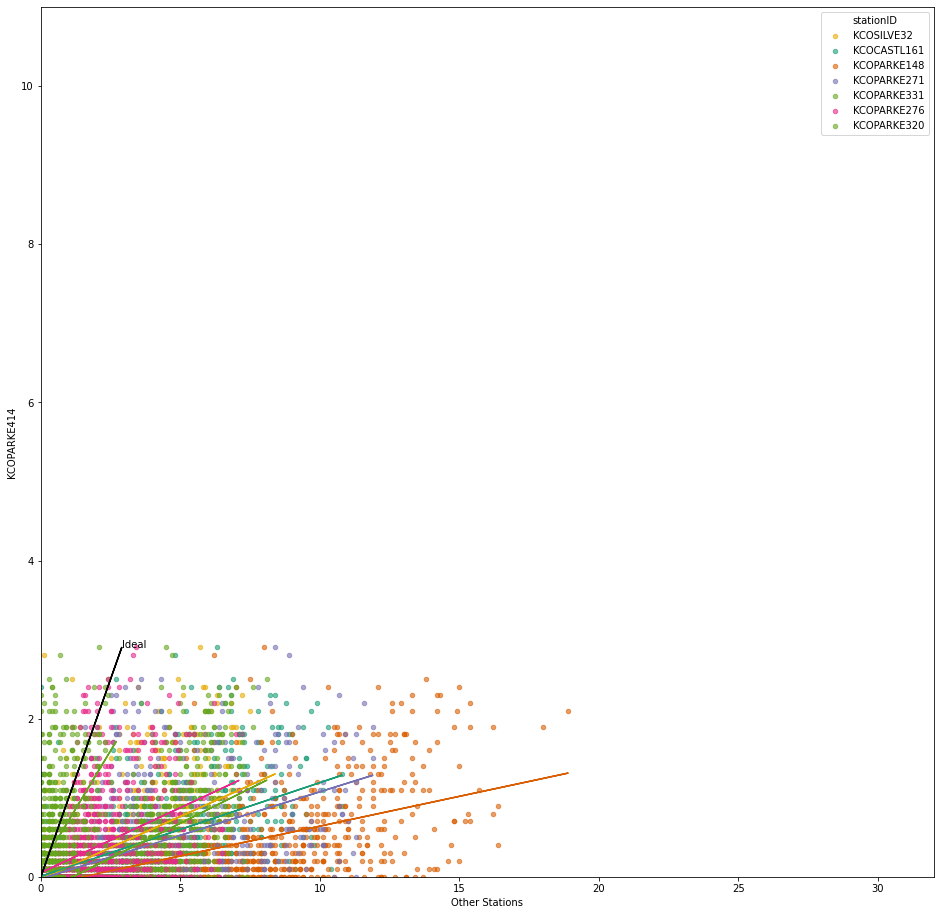

In [47]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=7)

df_reshaped = df_reshaped[~iso_outliers]
columns_to_plot = list(set(df_reshaped.columns))
columns_to_plot.remove(my_station)
i = 0
colors = 'rgbym'
cmap = cm.get_cmap('Dark2')
cmap_counter = 0.9

fig, ax = plt.subplots(figsize=(16,16))
# ax.set_aspect('equal')
# ax.set_xlim((0,30))
# ax.set_ylim((0,30))
for col in columns_to_plot:
  df_reshaped.plot(ax=ax, kind='scatter',y=my_station,x=col,color=cmap_tracker.get(col,cmap(cmap_counter)),label=col,alpha=0.6)
  m, b = np.polyfit(df_reshaped[col], df_reshaped[my_station], 1)
  # ax.plot(df_reshaped[my_station],m*df_reshaped[my_station]+b, color=colors[i])
  ax.plot(df_reshaped[col],m*df_reshaped[col]+b, color=cmap_tracker.get(col,cmap(cmap_counter))) #color=colors[i]
  i += 1
  cmap_counter -= .1
ax.plot(df_reshaped[my_station],df_reshaped[my_station],c='k')
ax.text(df_reshaped[my_station].max()+.01, df_reshaped[my_station].max(), 'Ideal')
ax.set_xlabel('Other Stations')
plt.xlim(0,32)
plt.ylim(0,11)
plt.show()


In [94]:
df_reshaped = get_top_n_correlated(df,corr_df,num_stations=7,variable=columns_to_pull)
X = np.array(df_reshaped.drop(columns=my_station))
y = np.array(df_reshaped[[my_station]]) #target
iso_forest = IsolationForest(n_estimators=200,verbose=True,random_state=42,bootstrap=True).fit(X,y)
iso_outliers = iso_forest.predict(X) ==-1
# np.sum(iso_outliers)
X_iso = X[~iso_outliers]
y_iso = y[~iso_outliers]
print('dropped {} ({:.2f}%) rows'.format((X.shape[0] - X_iso.shape[0]),100*(1-(X_iso.shape[0]/X.shape[0]))))

X_train, X_test, y_train, y_test = train_test_split(X_iso,y_iso,test_size=0.3)

model = LinearRegression()
model.fit(X_train,y_train)

scores = cross_val_score(model,X_test,y_test)
print('Regression scores: {}\nAverage Score: {:.2f} Std: {:.2f}'.format(scores,np.mean(scores),np.std(scores) ))

model = Ridge()
model.fit(X_train,y_train)

scores = cross_val_score(model,X_test,y_test)
print('Ridge scores: {}\nAverage Score: {:.2f} Std: {:.2f}'.format(scores,np.mean(scores),np.std(scores) ))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


dropped 174 (12.79%) rows
Regression scores: [0.64489372 0.35044976 0.53490341 0.60319508 0.51929948]
Average Score: 0.53 Std: 0.10
Ridge scores: [0.63453624 0.3452909  0.53166901 0.61241765 0.5424267 ]
Average Score: 0.53 Std: 0.10


In [93]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

model = Ridge()
model.fit(X_train,y_train)

scores = cross_val_score(model,X_test,y_test)
print('scores: {}\nAverage Score: {:.2f} Std: {:.2f}'.format(scores,np.mean(scores),np.std(scores) ))


scores: [0.7551223  0.72922147 0.8834811  0.78140609 0.86751554]
Average Score: 0.80 Std: 0.06


In [ ]:
for k, model in model_dict.items() :
  # model = svr_poly
  scores = []
  kfold = KFold(n_splits=3, shuffle=True, random_state=42)

  for i, (train, test) in enumerate(kfold.split(X_iso, y_iso)):
    model.fit(X_iso[train,:], y_iso[train,:].ravel())
    score = model.score(X_iso[test,:], y_iso[test,:].ravel())
    scores.append(score)
  print(k)
  print(scores)

svr_lin
[0.45423164909737745, 0.49443940682899995, 0.5381713821148104]
svr_poly
[0.4756545318151152, 0.5651893313262781, 0.6588051946370239]


In [ ]:
X_iso_train, X_iso_test, y_iso_train, y_iso_test = train_test_split(X_iso,y_iso,test_size=0.3)

In [ ]:
df_reshaped, num_dropped = get_top_n_correlated(df,corr_df,num_stations=9)
X = pd.DataFrame(df_reshaped.drop(columns=my_station))
y = pd.DataFrame(df_reshaped[[my_station]]) #target
model = Ridge(alpha=.5)
scores = cross_val_score(model,X,y)
scores

array([0.47198298, 0.82394038, 0.46078631, 0.43308191, 0.67597924])

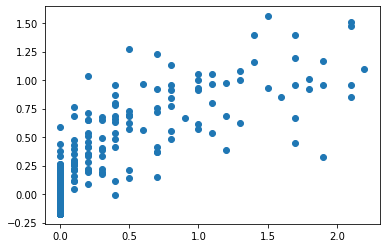

In [ ]:
y_iso_preds = model.fit(X_iso_train,y_iso_train).predict(X_iso_test)
plt.scatter(y_iso_test, y_iso_preds)
plt.show()


In [ ]:
# print("Accuracy: ", accuracy_score(y_test, y_pred))
# print('f1 score: ',f1_score(y_test,y_pred), 'with grid parameters:')
print(grid.best_params_)

{'classify__max_depth': 75, 'classify__max_features': 'log2', 'classify__n_estimators': 50}


In [ ]:
scores = cross_val_score(grid,X_test,y_test)
scores

array([0.63270121, 0.79572657, 0.71368964, 0.59123237, 0.77087991])

In [ ]:
X_train.flatten()

array([5.8, 5.9, 0.5, ..., 0.5, 0. , 1.6])

In [ ]:
poly = PolynomialFeatures(degree=-2)
poly.fit_transform(X_train)

IndexError: ignored

In [ ]:
x_train_poly = poly.fit_transform(X_train)
# model = LinearRegression.fit(x_train_poly[:, np.newaxis],y_train)
# model.score(X_test, y_test)


IndexError: ignored

In [ ]:
X_train.shape

(876, 5)